## 범죄 데이터셋 + CCTV 데이터셋
1. 각 데이터셋의 전처리 수행
2. 분석을 위한 병합
3. 상관관계 분석 (pearson)

In [40]:
# 필요한 library 호출
import pandas as pd
import numpy as np

def preprocess_crime(crime_csv_path):
    """
    서울시 5대 범죄 발생현황 통계(2020-2024).csv 전처리 수행
    1. wide형식을 long 형식으로 변환
    2. 자치구, 연도, 범죄유형, 발생, 검거 열
    3. 연도와 범죄유형별 소계를 이용해서 '범죄율=전체 중 비중', '검거율=비중' 계산
    
    산출물 : crime_df(-> columns : [자치구, 연도, 범죄유형, 발생, 검거, 범죄율, 검거율])
    """
    
    raw_data = pd.read_csv(crime_csv_path)
    
    #헤더 정리
    crime_row = raw_data.iloc[1]
    stat_row = raw_data.iloc[2]
    
    data = raw_data.iloc[3:].reset_index(drop = True)
    data = data.rename(columns = {
        "자치구별(1)":"구분",
        "자치구별(2)": "자치구"
    })
    
    #wide table -> long table 변환
    long_rows = []
    for col in data.columns[2:]:
        year_str = str(col).split('.')[0] #현재 2020.1이라 되어있는 부분 수정 필요
        if not year_str.isdigit():
            continue
        
        year = int(year_str)
        crime_type = crime_row[col]
        stat_type = stat_row[col] #'발생' or '검거'
        
        tmp = data[["구분", "자치구"]].copy()
        tmp["연도"] = year
        tmp["범죄유형"] = crime_type
        tmp["구분_발생검거"] = stat_type
        tmp["값"] = pd.to_numeric(data[col], errors = "coerce")
        
        long_rows.append(tmp)
        
    long_df = pd.concat(long_rows, ignore_index = True)
    
    #pivot_df : 발생/검거 컬럼으로 분리
    pivot_df = (
        long_df.pivot_table(
            index = ["구분", "자치구", "연도", "범죄유형"],
            columns = "구분_발생검거",
            values = "값"
        ).reset_index()
    )
    pivot_df.columns.name = None
    
    if '발생' not in pivot_df.columns:
        pivot_df['발생'] = 0
    if '검거' not in pivot_df.columns:
        pivot_df['검거'] = 0 
        
    pivot_df['발생'] = pivot_df['발생'].fillna(0).astype("int64")
    pivot_df['검거'] = pivot_df['검거'].fillna(0).astype("int64")
    
    # 범죄율, 검거율 (전체에 대한 비중) 계산
    totals = (
        pivot_df.groupby(['연도','범죄유형'])[['발생', '검거']].sum().reset_index().rename(columns = {'발생': '전체발생', '검거':"전체검거"})
    )
    
    crime_df = pivot_df.merge(totals, on = ['연도', '범죄유형'], how = 'left')
    
    #열 추가
    crime_df['검거율'] = crime_df['검거']/crime_df['전체검거']
    crime_df['범죄율'] = crime_df['발생']/crime_df['전체발생']
    
    #완성!
    return crime_df


In [41]:
def add_crime_rate_changes(crime_df):
    """
    범죄율과 검거율의 연도별 변화량(단순 차/pct_change(백분율))
    추가 열: 범죄율 변화(전년대비), 검거율 변화, 범죄율_변화율, 검거율_변화율
    """
    df = crime_df.copy()
    df = df.sort_values(['자치구','범죄유형','연도'])
    
    group_cols = ['자치구','범죄유형']
    
    df['범죄율_변화'] = df.groupby(group_cols)['범죄율'].diff()
    df['검거율_변화'] = df.groupby(group_cols)['검거율'].diff()
    df['범죄율_변화율'] = df.groupby(group_cols)['범죄율'].pct_change()
    df['검거율_변화율'] = df.groupby(group_cols)['검거율'].pct_change()
    
    crime_change_df = df.copy()
    
    
    return crime_change_df

In [42]:

def detect_significant_changes(crime_change_df, threshold_abs, use_ratio, threshold_ratio):
    """_summary_

    Args:
        crime_change_df (_type_): pd.DataFrame
        threshold_abs (_type_): float
        use_ratio (_type_): bool
        threshold_ratio (_type_): float
        
    연도별 변화율이 유의미한 구간을 찾는 함수 (임계치를 넘는 구간)
    반환 : significant_df: 조건을 만족하는 자치구,연도, 범죄유형만 남긴 데이터
    """
    
    df = crime_change_df.copy()
    
    cond_abs = (df['범죄율_변화'].abs() >= threshold_abs) | \
        (df['검거율_변화'].abs() >= threshold_abs)
        
    if use_ratio:
        cond_ratio = (df['범죄율_변화율'].abs() >= threshold_ratio) | \
            (df['검거율_변화율'].abs() >= threshold_ratio)
        cond = cond_abs | cond_ratio
    else:
        cond = cond_abs
    
    significant_df = df[cond].copy()
    return significant_df

In [43]:
def preprocess_cctv_normal(cctv_csv_path):
    """_summary_
    '서울시 자치구 연도별 CCTV 설치 현황'의 전처리 함수
    - 2020~2024년도만 활용(연도 통일 목적)
    - 자치구, 연도, 일반 CCTV 설치수 형태의 Long 형식으로 변환할 예정
    Args:
        cctv_csv_path (_type_): pd.DataFrame
    """
    raw = pd.read_csv(cctv_csv_path, encoding = 'utf-8', engine = 'python')
    
    # 헤더 정리( 실제 데이터 부분을 쓰기 위함)
    header = raw.iloc[1]
    df = raw.iloc[2:].copy()
    df.columns = header
    
    #계, NaN 제거
    df = df[df['자치구'].notna()]
    df = df[df['자치구'] != '계']
    df['자치구'] = df['자치구'].str.replace(" ",'')
    
    #연도 추출
    year_cols = ['2020년', '2021년', '2022년','2023년','2024년']
    df_year = df[['자치구']+year_cols].copy()
    
    #type str -> int변환
    for col in year_cols:
        df_year[col] = (
            df_year[col].astype(str).str.replace(",", '', regex = False).str.strip().replace("-",'0').replace('nan','0')
        )
        df_year[col] = pd.to_numeric(df_year[col], errors = 'coerce')
        
    #long 포맷 변환
    cctv_long = df_year.melt(
        id_vars = '자치구',
        value_vars = year_cols,
        var_name = "연도",
        value_name = "일반CCTV_설치수"
    )
    cctv_long['연도'] = cctv_long["연도"].str.replace("년","").astype(int)
    
    return cctv_long

In [44]:
def preprocess_cctv_smart(smart_csv_path):
    """_summary_
    '서울시 자치구 지능형 CCTV 설치 현황'의 전처리 함수
    - 2020~2024년도만 활용(연도 통일 목적)
    - 자치구, 연도, 일반 CCTV 설치수 형태의 Long 형식으로 변환할 예정
    Args:
        smart_csv_path (_type_): pd.DataFrame
    전체 형식은 위의 일반형 cctv와 같음. 반환만 smart cctv!
    """
    raw = pd.read_csv(smart_csv_path, encoding = 'utf-8', engine = 'python')
    
    # 헤더 정리( 실제 데이터 부분을 쓰기 위함)
    header = raw.iloc[1]
    df = raw.iloc[2:].copy()
    df.columns = header
    
    #계, NaN 제거
    df = df[df['자치구'].notna()]
    df = df[df['자치구'] != '계']
    df['자치구'] = df['자치구'].str.replace(" ",'')
    
    #연도 추출
    year_cols = ['2020년', '2021년', '2022년','2023년','2024년']
    df_year = df[['자치구']+year_cols].copy()
    
    #type str -> int변환
    for col in year_cols:
        df_year[col] = (
            df_year[col].astype(str).str.replace(",", '', regex = False).str.strip().replace("-",'0').replace('nan','0')
        )
        df_year[col] = pd.to_numeric(df_year[col], errors = 'coerce')
        
    #long 포맷 변환
    smart_long = df_year.melt(
        id_vars = '자치구',
        value_vars = year_cols,
        var_name = "연도",
        value_name = "지능형CCTV_설치수"
    )
    smart_long['연도'] = smart_long["연도"].str.replace("년","").astype(int)
    
    return smart_long

In [45]:
def merge_for_analysis(significant_crime_df, normal_cctv_long, smart_cctv_long):
    """_summary_
    연도별 범죄율/검거율 변화가 크게 튄 구간과 해당 연도의 cctv 설치수 정보를 merge함
    key = 자치구, 연도
    Args:
        significant_crime_df (_type_): pd.DataFrame
        normal_cctv_long (_type_): pd.DataFrame
        smart_cctv_long (_type_): pd.DataFrame
    """
    merged = significant_crime_df.merge(
        normal_cctv_long,
        on = ["자치구", "연도"],
        how= 'left'
    ).merge(smart_cctv_long, on=['자치구', '연도'], how = 'left')
    
    return merged

In [46]:
def compute_correlations(merged_df):
    """_summary_
    CCTV 설치수와 범죄율/검거율 변화량 사이의 피어슨 상관계수 계산
    - 일반 CCTV 설치수, 지능형 CCTV 설치수
    vs
    - 범죄율_변화, 검거율_변화
    Args:
        merged_df (_type_): pd.DataFrame
    return: corr_table
    """
    cols_for_corr = [
        "범죄율_변화",
        "검거율_변화",
        "일반CCTV_설치수",
        "지능형CCTV_설치수"
    ]
    subset = merged_df[cols_for_corr].dropna()
    corr_table = subset.corr(method = 'pearson')
    
    return corr_table

In [47]:
def main():
    """
    전체 실행
    1. 범죄 데이터 전처리 + 변화량 계산
    2. 임계치를 기반으로 한 '이상변동 구간' 탐지
    3. 일반/ 지능형 CCTV 전처리
    4. 범죄 변화구간 + CCTV 병합
    5. 상관계수 계산
    """
    #파일 경로(상대경로로 지정)
    crime_csv_path = "서울시 5대범죄 발생현황 통계(2020-2024).csv"
    normal_cctv_csv_path = "서울시 자치구 (연도별) CCTV 설치현황(25.6.30 기준).csv"
    smart_cctv_csv_path = "서울시 자치구 지능형 CCTV 설치현황(25.6.30 기준).csv"
    
    #임계치 설정
    threshold_abs = 0.02
    use_ratio = False #이 값을 True로 하면 상대 변화율(pct_change), False로 하면 diff(단순 차이)의 결과를 보실 수 있습니다.
    threshold_ratio = 0.03
    
    #범죄데이터 전처리, 변화량 계산
    crime_df=preprocess_crime(crime_csv_path)
    crime_change_df = add_crime_rate_changes(crime_df)
    
    #이상변동 구간 탐지
    significant_df = detect_significant_changes(
        crime_change_df,
        threshold_abs = threshold_abs,
        use_ratio = use_ratio,
        threshold_ratio = threshold_ratio
    )
    
    #CCTV 데이터 전처리
    normal_cctv_long = preprocess_cctv_normal(normal_cctv_csv_path)
    smart_cctv_long = preprocess_cctv_smart(smart_cctv_csv_path)
    
    #merge
    merged_for_analysis = merge_for_analysis(
        significant_df,
        normal_cctv_long,
        smart_cctv_long
    )
    
    #corr
    corr_table = compute_correlations(merged_for_analysis)
    print(corr_table)
    
    #이후 시각화를 위한 결과 저장
    crime_change_df.to_csv("범죄_전처리_및_변화량.csv", index = False, encoding = 'utf-8-sig')
    significant_df.to_csv("이상변동_구간_범죄데이터.csv", index = False, encoding = 'utf-8-sig')
    merged_for_analysis.to_csv("이상변동_구간_CCTV_결합데이터.csv", index = False, encoding = 'utf-8-sig')
    corr_table.to_csv("CCTV_범죄변화_상관계수.csv", encoding = 'utf-8-sig')

    
main()

               범죄율_변화    검거율_변화  일반CCTV_설치수  지능형CCTV_설치수
범죄율_변화       1.000000  0.932305   -0.158464    -0.127422
검거율_변화       0.932305  1.000000   -0.082045    -0.111346
일반CCTV_설치수  -0.158464 -0.082045    1.000000     0.458351
지능형CCTV_설치수 -0.127422 -0.111346    0.458351     1.000000


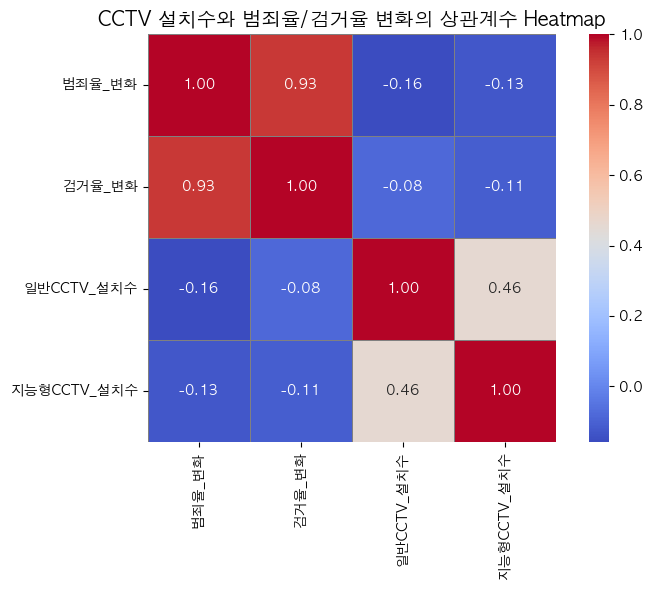

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
#한글폰트 깨짐 방지용
#plt.rcParams['font.family'] = 'NanumGothic'
#plt.rcParams['font.family'] = 'Noto Sans CJK KR'

plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False
#조교님꼐서 실행시 윈도우 환경이시라면 아래의 폰트 설정을 시행해주시면 되겠습니다.
#plt.rcParams['font.family'] = 'Malgun Gothic'
corr_table = pd.read_csv("CCTV_범죄변화_상관계수.csv", index_col = 0)
corr_table = corr_table.apply(pd.to_numeric, errors = 'coerce')
plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_table,
    annot=True,          # 숫자 표시
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    square=True
)

plt.title("CCTV 설치수와 범죄율/검거율 변화의 상관계수 Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


## 범죄 + CCTV + 유흥업소 데이터셋
1. 유흥업소 데이터 전처리 과정
2. 세 데이터셋 병합
3. 상관계수 비교

In [49]:

def preprocess_play(play_csv_path):
    """_summary_
    서울시 유흥주점영업 인허가 정보의 전처리 코드
    - 인허가 일자에서 연도만 추출(2020~2024)
    - '영업/정상'으로 표시된 영업중인 업체만 남기기
    - 주소/법정동명 등에서 자치구 이름 추출
    - 연도, 자치구별 유흥업소 개수를 집계함
    Args:
        play_csv_path (_type_): pd.DataFrame
    Return:
    club_yearly (_type_): DataFrame
     -> columns = ['자치구', '연도', '유흥업소_수']
    """
    raw_play = pd.read_csv("서울시 유흥주점영업 인허가 정보.csv", encoding = 'cp949')
    
    #컬럼 선택
    cols_keep = ['인허가일자', '영업상태명', '도로명주소', '사업장명']
    play = raw_play[cols_keep].copy()
    
    #도로명 주소에서 자치구만 추출
    play['자치구'] = (
        play['도로명주소'].astype(str).str.extract(r'([가-힣]+구)', expand = False)
    )
    #인허가일자에서 연도만 추출
    play['인허가일자'] = pd.to_datetime(play['인허가일자'], errors = 'coerce')
  
    #영업상태 영업/정상인 업소만
    play = play[play['영업상태명'] == '영업/정상']
    
    #자치구 결측치 제거
    play = play.dropna(subset = ['자치구'])
    
    #영업중인 업소수 계산
    years = [2020,2021,2022,2023,2024]
    result = []
    
    #연도, 자치구별 유흥업소 수 집계 만들기
    
    for y in years:
        cutoff = pd.Timestamp(y,12,31)
        tmp = play[play['인허가일자'] <= cutoff]

        counts = (
            tmp.groupby('자치구').size().reset_index(name = '유흥업소_수')
        )
        counts['연도'] = y
        result.append(counts)
    club_yearly = (
        pd.concat(result,ignore_index = True).sort_values(['자치구', '연도']).reset_index(drop = True)
    ) 
    
    club_yearly['유흥업소_증감'] = (
        club_yearly.groupby('자치구')['유흥업소_수'].diff().fillna(0)
    )
    
    return club_yearly

In [50]:
def merge_with_club(merged_for_analysis, club_yearly):
    """_summary_
    기존 merged_for_analysis 데이터에 유흥업소 수를 left merge함
    Args:
        merged_for_analysis (_type_): pd.DataFrame
        club_yearly (_type_): pd.DataFrame
    """
    merged_with_club = merged_for_analysis.merge(
        club_yearly,
        on = ['자치구', '연도'],
        how = 'left'
    )
    return merged_with_club

In [51]:
def corr_with_club(merged_with_club):
    """_summary_
    범죄율 변화, 검거율 변화, CCTV설치수, 유흥업소 증감 간 상관계수 행렬을 계산하여 반환함
    Args:
        merged_with_club (_type_): pd.DataFrame
    """
    
    import pandas as pd
    cols = [
        "범죄율_변화",
        "검거율_변화",
        "일반CCTV_설치수",
        '지능형CCTV_설치수',
        '유흥업소_증감',
    ]
    
    cols = [c for c in cols if c in merged_with_club.columns]
    corr_table = merged_with_club[cols].apply(pd.to_numeric,errors = 'coerce').corr()
    
    return corr_table
    

In [52]:

###---main---###
#유흥업소 전처리
club_yearly = preprocess_play("서울시 유흥주점영업 인허가 정보.csv")

#병합
merged_for_analysis = pd.read_csv('이상변동_구간_CCTV_결합데이터.csv')
merged_with_club = merge_with_club(merged_for_analysis, club_yearly)

#상관계수 분석
corr_table = corr_with_club(merged_with_club)
print(corr_table)

               범죄율_변화    검거율_변화  일반CCTV_설치수  지능형CCTV_설치수   유흥업소_증감
범죄율_변화       1.000000  0.932497   -0.098462    -0.127422  0.156792
검거율_변화       0.932497  1.000000   -0.054630    -0.111346  0.142238
일반CCTV_설치수  -0.098462 -0.054630    1.000000     0.458351  0.182208
지능형CCTV_설치수 -0.127422 -0.111346    0.458351     1.000000  0.139245
유흥업소_증감      0.156792  0.142238    0.182208     0.139245  1.000000


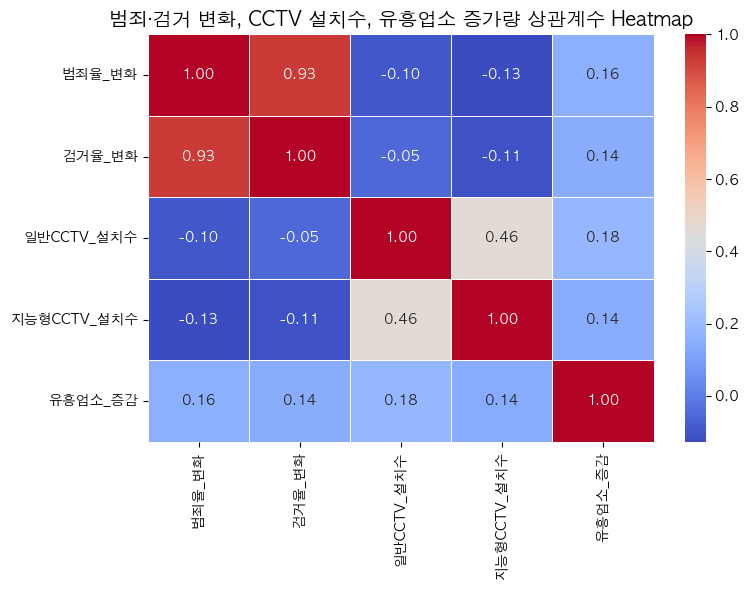

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_table,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("범죄·검거 변화, CCTV 설치수, 유흥업소 증가량 상관계수 Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


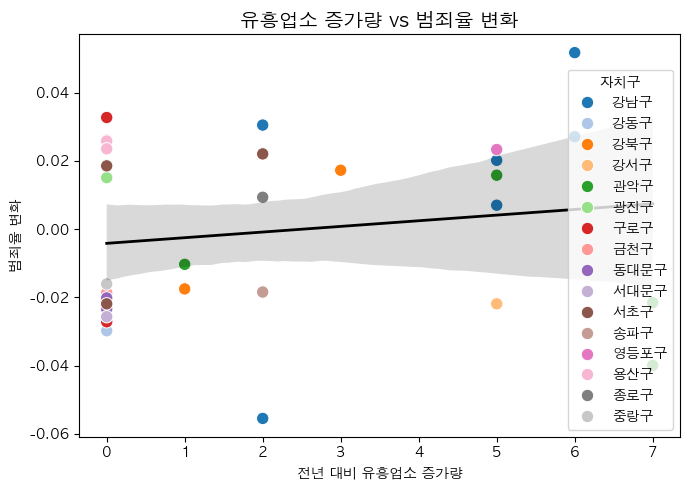

In [54]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='범죄율_변화',
    hue='자치구',
    palette='tab20',
    s=80
)
sns.regplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='범죄율_변화',
    scatter=False,
    color='black',
    line_kws={'linewidth':2}
)

plt.title("유흥업소 증가량 vs 범죄율 변화", fontsize=14)
plt.xlabel("전년 대비 유흥업소 증가량")
plt.ylabel("범죄율 변화")
plt.tight_layout()
plt.show()


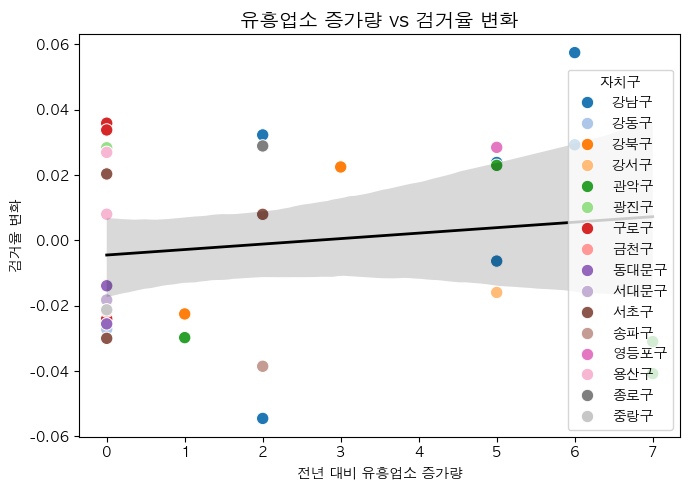

In [55]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='검거율_변화',
    hue='자치구',
    palette='tab20',
    s=80
)
sns.regplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='검거율_변화',
    scatter=False,
    color='black',
    line_kws={'linewidth':2}
)

plt.title("유흥업소 증가량 vs 검거율 변화", fontsize=14)
plt.xlabel("전년 대비 유흥업소 증가량")
plt.ylabel("검거율 변화")
plt.tight_layout()
plt.show()


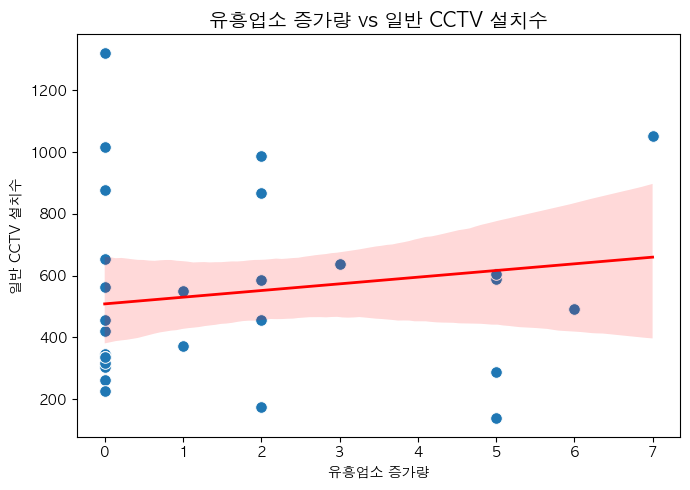

In [56]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='일반CCTV_설치수',
    s=70
)
sns.regplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='일반CCTV_설치수',
    scatter=False,
    color='red',
    line_kws={'linewidth':2}
)

plt.title("유흥업소 증가량 vs 일반 CCTV 설치수", fontsize=14)
plt.xlabel("유흥업소 증가량")
plt.ylabel("일반 CCTV 설치수")
plt.tight_layout()
plt.show()


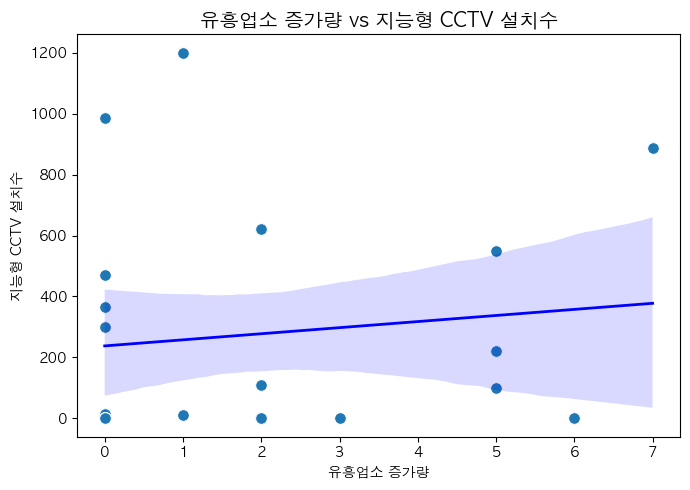

In [57]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='지능형CCTV_설치수',
    s=70
)
sns.regplot(
    data=merged_with_club,
    x='유흥업소_증감',
    y='지능형CCTV_설치수',
    scatter=False,
    color='blue',
    line_kws={'linewidth':2}
)

plt.title("유흥업소 증가량 vs 지능형 CCTV 설치수", fontsize=14)
plt.xlabel("유흥업소 증가량")
plt.ylabel("지능형 CCTV 설치수")
plt.tight_layout()
plt.show()
